# *Stock Market Prediction Using stacked LSTM*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Input
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Dropout, Add

In [2]:
df = pd.read_csv(r"C:\Users\OmkarRPrabhu\OneDrive - iitgn.ac.in\Desktop\Projects\Stock_Price_Prediction_NVDA\NVDA.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-09-03,4.11450,4.14775,4.08125,4.10425,4.084733,296140000
1,2019-09-04,4.16525,4.22650,4.16525,4.21900,4.198936,227728000
2,2019-09-05,4.32175,4.49975,4.32000,4.49350,4.472132,695676000
3,2019-09-06,4.47000,4.52725,4.42800,4.46625,4.445012,376976000
4,2019-09-09,4.49750,4.59950,4.49600,4.51250,4.491042,417524000


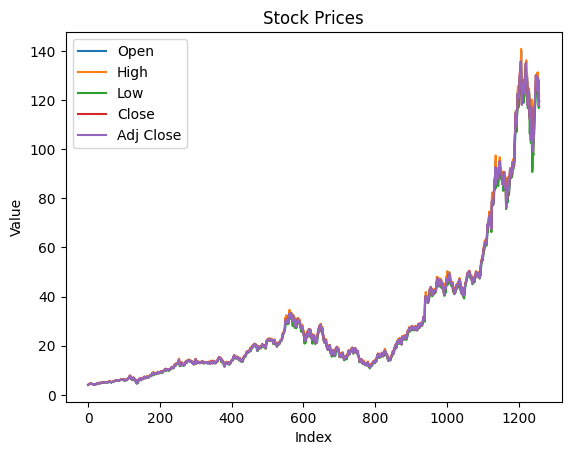

In [3]:
# Plot each column with a label for the legend
plt.plot(df['Open'], label='Open')
plt.plot(df['High'], label='High')
plt.plot(df['Low'], label='Low')
plt.plot(df['Close'], label='Close')
plt.plot(df['Adj Close'], label='Adj Close')

# Add a legend to the plot
plt.legend()

# Optionally, add labels and a title for clarity
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Stock Prices')

# Display the plot
plt.show()


In [4]:
df = df.reset_index()['Close']

In [5]:
df_actual = df

In [6]:
df.shape

(1258,)

In [7]:
#LSTM's are sensitive to the scale of the date. So we apply the MinMax Scaler

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))  # to make the data value only between 0 to 1
df = scaler.fit_transform(np.array(df).reshape(-1,1))
df

array([[0.00000000e+00],
       [8.72784512e-04],
       [2.96062197e-03],
       ...,
       [9.24168519e-01],
       [8.63168640e-01],
       [8.76707311e-01]])

##### *Splitting into Train and Test dataset* 


In [8]:
train_data_size = int(len(df)*0.7)

train_data , test_data = df[0:train_data_size , :] , df[train_data_size:len(df) , :]

df.size , train_data.size , test_data.size , train_data.size + test_data.size

(1258, 880, 378, 1258)

##### *Creating the Dataset*
- Let us suppose we have the data as 100, 120, 130, 140, 135, 144, 166, 123, 122.
- Then, if we consider the timesteps to be 3.
- `X_train` would be like:

\begin{bmatrix}
100 & 120 & 130 \\
120 & 130 & 140 \\
130 & 140 & 135 \\
140 & 135 & 144 \\
135 & 144 & 166 \\
144 & 166 & 123 \\
166 & 123 & 122
\end{bmatrix}


- And `y_train` would be like:

\begin{bmatrix}
140 \\
135 \\
144 \\
166 \\
123 \\
122
\end{bmatrix}



In [9]:
def create_dataset(dataset , timesteps) :
    X_train = [] 
    Y_train = [] 
    for i in range(len(dataset)-timesteps-1) : 
        X_train.append(dataset[i:timesteps+i]) 
        Y_train.append(dataset[timesteps+i+1])
    return np.array(X_train) , np.array(Y_train) 

In [10]:
timesteps = 100 
X_train , Y_train = create_dataset(train_data , timesteps) 
X_test , Y_test = create_dataset(test_data , timesteps) 

#### *LSTM Model*

In [11]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [12]:
# Define LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(timesteps, 1)),
    LSTM(50, return_sequences=True),
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(1)
])

c:\Users\OmkarRPrabhu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Train the LSTM model
lstm_history = lstm_model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_data=(X_test, Y_test), verbose=1)


Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - loss: 1.7277e-04 - val_loss: 0.0525
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 213ms/step - loss: 1.4056e-04 - val_loss: 0.0494
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 206ms/step - loss: 1.5655e-04 - val_loss: 0.0583
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step - loss: 1.7693e-04 - val_loss: 0.0384
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - loss: 1.5726e-04 - val_loss: 0.0364
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - loss: 1.7018e-04 - val_loss: 0.0608
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - loss: 1.6711e-04 - val_loss: 0.0655
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - loss: 2.1077e-04 - val_loss: 0.0331
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - loss: 1.4576e-04 - val_loss: 0.0314
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 207ms/step - loss: 1.5815e-04 - val_loss: 0.0441
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - loss: 1.3188e-04 - val_loss: 0.04

In [21]:
predicted = lstm_model.predict(X_test)
predicted

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


array([[0.2888262 ],
       [0.28967687],
       [0.29440054],
       [0.30155495],
       [0.30816   ],
       [0.31157604],
       [0.30670345],
       [0.2974576 ],
       [0.28970096],
       [0.28768012],
       [0.28868824],
       [0.285696  ],
       [0.2791389 ],
       [0.26967725],
       [0.26733184],
       [0.2730985 ],
       [0.2811212 ],
       [0.28661418],
       [0.2883146 ],
       [0.2952378 ],
       [0.30341583],
       [0.311573  ],
       [0.31748363],
       [0.31725836],
       [0.31408453],
       [0.31523103],
       [0.3212942 ],
       [0.32835275],
       [0.3308643 ],
       [0.32865724],
       [0.32099807],
       [0.30995157],
       [0.29880324],
       [0.29034087],
       [0.2855728 ],
       [0.2858195 ],
       [0.28971225],
       [0.29089168],
       [0.28889504],
       [0.28506893],
       [0.2789476 ],
       [0.27034405],
       [0.26381224],
       [0.26284647],
       [0.26566184],
       [0.27068493],
       [0.276988  ],
       [0.283

In [22]:
train_predict  = lstm_model.predict(X_train)
test_predict = lstm_model.predict(X_test)  

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


In [23]:
train_predict_lstm = scaler.inverse_transform(train_predict)
test_predict_lstm = scaler.inverse_transform(test_predict)

In [24]:
Y_train_actual = scaler.inverse_transform(Y_train)
Y_test_actual = scaler.inverse_transform(Y_test)

In [25]:
import math 
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(Y_train_actual , train_predict_lstm)) , math.sqrt(mean_squared_error(Y_test_actual , test_predict_lstm))


(1.0119480429009555, 11.087864212468896)

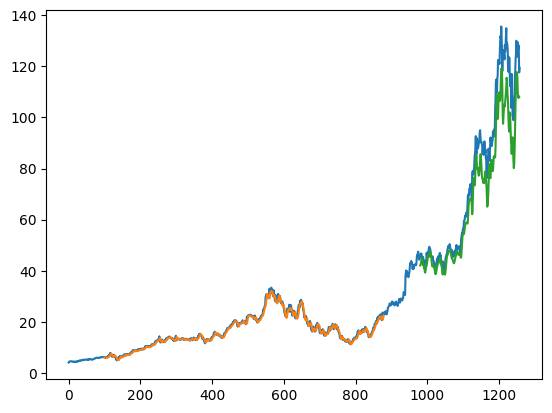

In [26]:

# Shifting the train predictions for plotting 
look_back = 100 
trainPredictPlot = np.empty_like(df)
trainPredictPlot[: , :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict_lstm


# Shifting the test predictions for plotting 
testPredictPlot = np.empty_like(df)
testPredictPlot[: , :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df)-1, :] = test_predict_lstm


#Plot 
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


---

# *Stock Market Prediction Using GRU*

In [27]:
# Define GRU model
gru_model = Sequential([
    GRU(50, return_sequences=True, input_shape=(timesteps, 1)),
    GRU(50, return_sequences=True),
    GRU(50, return_sequences=True),
    GRU(50),
    Dense(1)
])

c:\Users\OmkarRPrabhu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
gru_model.compile(optimizer='adam', loss='mean_squared_error')
gru_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 100, 50)        │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 100, 50)        │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 100, 50)        │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,901 (210.55 KB)

 Trainable params: 53,901 (210.55 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Train the GRU model
gru_history = gru_model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_data=(X_test, Y_test), verbose=1)


Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 233ms/step - loss: 0.0041 - val_loss: 0.1041
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - loss: 6.0317e-04 - val_loss: 0.0114
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - loss: 1.5304e-04 - val_loss: 0.0029
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - loss: 1.3655e-04 - val_loss: 0.0085
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - loss: 1.1341e-04 - val_loss: 0.0043
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - loss: 1.0321e-04 - val_loss: 0.0058
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - loss: 1.0710e-04 - val_loss: 0.0052
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - loss: 1.0925e-04 - val_loss: 0.0046
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - loss: 9.6324e-05 - val_loss: 0.0047
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - loss: 1.0146e-04 - val_loss: 0.0047
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - loss: 1.0530e-04 - val_loss: 0.0042


In [30]:
train_predict_gru  = gru_model.predict(X_train)
test_predict_gru = gru_model.predict(X_test)  

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [31]:
train_predict_gru = scaler.inverse_transform(train_predict_gru)
test_predict_gru = scaler.inverse_transform(test_predict_gru)

In [32]:
import math 
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(Y_train_actual , train_predict_gru)) , math.sqrt(mean_squared_error(Y_test_actual , test_predict_gru))


(0.9268227814733855, 9.709491885214476)

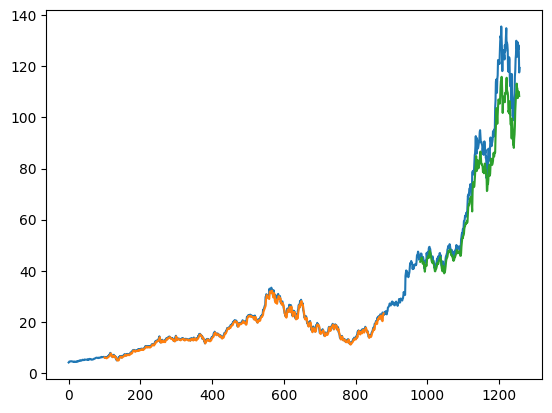

In [33]:

# Shifting the train predictions for plotting 
look_back = 100 
trainPredictPlot = np.empty_like(df)
trainPredictPlot[: , :] = np.nan
trainPredictPlot[look_back:len(train_predict_gru)+look_back, :] = train_predict_gru


# Shifting the test predictions for plotting 
testPredictPlot = np.empty_like(df)
testPredictPlot[: , :] = np.nan
testPredictPlot[len(train_predict_gru)+(look_back*2)+1:len(df)-1, :] = test_predict_gru


#Plot 
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


---